## Tensorflow test code

** Lance Martin **

** Simple model implementations in TF along with refresher notes from: **

* Andrej Karpathy, Fei Fei Li, Justin Johnson - [Stanford CS231n](http://cs231n.stanford.edu/) 
* Google TensorFlow tutorial

---

### Gradient-based supervised learning machines

(1) **Machine:** With adjustable knobs (parameters) -

* May be simple (Perceptron, Rosenblatt 1957) or complex (DNN) machine.

(2) **Decision rule:**  Map input to a class label -

* A decision rule $y = F(W,X)$ where $F()$ is some function pass $W$ (learned parameters) and input $X$. 

(3) **Loss function:** Measure the error between chosen class and true class -

* Many choices for loss function (e.g., squared error, log likelihood, cross-entropy, etc).

(4) **Gradient / optimization:** Use gradient to figure out what direction to tune the knobs to reduce the error -

* Ideally, the gradient of the loss function with respect to weights can be used.

---

### Linear machines for image classification

** $W$ as template **  

* $X$ is an array of pixels (e.g., `1x4`). 
* $W$ (e.g., `4x3`) applies a learned weight to each pixel in the input and maps input to class scores.
* Each row of $W$ is a seperate classifier, liking (attributing high score) to certain pixels for certain classes.

** Linear decision boundary **

* A class score of zero means we are indifferent about classification:

$$ f(W,X) = W_1 X_1 + W_2 X_2 + b = 0 $$

* We can re-arrange to get all pairs of pixels that return a class score of zero (forming a line in 2D space):
 
$$ X_2 = -\frac{W_1}{W_2} X_1 - \frac{b}{W_2} $$

* This is a linear hyperplane in higher dimensional space.

---


### Case for neural networks

** Selectivity–invariance dilemma **

* *** Selectivity: ***  selective to aspects of the image that are important for discrimination. 
* ***  Invariance: *** invariant to irrelevant aspects (e.g., position, orientation, illumination).

** Challenge for shallow classifiers **

* $X$ is an array of pixels (e.g., `1x4`). 
* For a shallow classifier, there is **one** car template in $W$ that must be invariant to color, orientation, etc.

** Deep networks use hidden layers to include many class templates **

* Deep classifiers use intermediate (hidden) layers that map the input into $h$ dimensions (e.g., $W_h$ is `4xh`).
* The class decision is then the made by summing across the $h$ dimensions (e.g., $W_c$ is `hx4`).
* This means that there can be **many** templates in $W_h$ that fire in response to different car orientations.

** Deep networks use non-linear operations between layers to learn complex decision rules  **

* The final class decision is simply a linear operation / classifier.
* But, we apply non-linear operations between network layers. 
* This allows us to map transform input such that it is linearly seperable as shown in [the ConvNet JS demo](http://cs.stanford.edu/people/karpathy/convnetjs/demo/classify2d.html).

--- 

###  Non-Linearities

*** `RelU` is reccomended *** 

* Linear if x > 0 and non-linear everywhere else.
* Accelerates convergence of stochastic gradient descent (e.g. 6x relative to tanH, sigmoid, Krizhevsky et al. 2012).

---

###  Loss

**  Softmax function and cross-entropy loss **

* We compute raw class scores from: $s = logits = W_c relu(X W_h)$.
* Exponentiate logits and then normalize to compute a vector that sums to one.
 
$$ L = - log \frac{e^{s_k}}{\sum_j e^{s_j}} $$ 

* As expected, lower loss with higher probability of the correct class.

In [1]:
import numpy as np
softmax = .95
- np.log(softmax)

0.051293294387550578

###  Gradient and optimization

** Objective **

* Our goal is to determine how to adjust weights in order to the minimize loss.
* Gradient is just the vector of partial derivatives of loss function with respect to network weights.

** Numerical: finite difference approximation **

* Add a small increment to one dim of the weight.
* Measure the new loss function and compute gradient (e.g., negative, if loss drops).
* Update the weight (e.g., the negative of the gradient).
 

In [2]:
# Add a small increment to w_o - 
h = 0.0001
w_o = .34
l_o = 1.25347 
print('Initial weight: %s'%w_o)

# See how loss changes and compute gradient - 
l_1 = 1.25322
grad = (l_1 - l_o) / h
print(grad)

# Update w_o using param step_size to specify increment -
step_size = 1e-4
w_o += - step_size * grad
print('New weight: %s'%w_o)

Initial weight: 0.34
-2.5
New weight: 0.34025


* The changing by a factor of -2.5 when we update the weight.

** Calculus: compute gradient **

* Of course, numerical approximiation will not scale to millions of weights.
* Instead, use calculus to compute the gradient.
* But, it's not obvious to define a function to compute gradient through a large circuit.


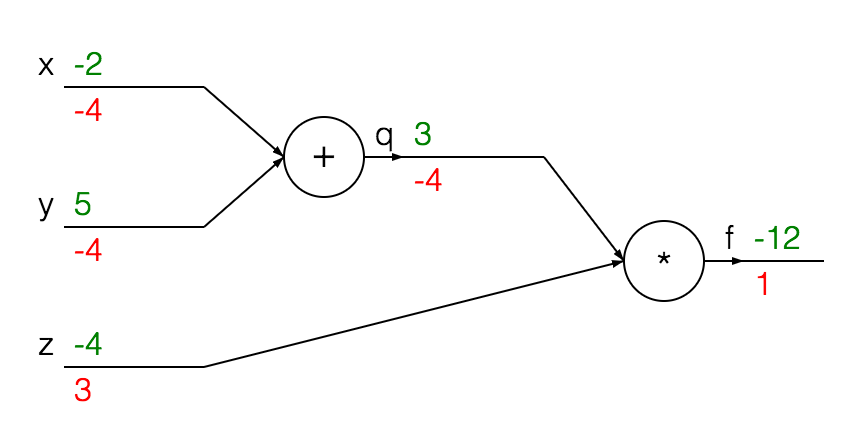

In [4]:
import os
from IPython.display import Image
Image(filename=os.getcwd()+'/img/circuit.png')

** Backprop: chain rule to link gradient through deep network **
 
* Chain rule to link: $\frac{df}{dx} = \frac{df}{dq} \frac{dq}{dx} $
* Since $f=qz$, then $\frac{df}{dq} = z = -4$.
* Since $q=x+y$, then $\frac{dq}{dx} = 1$. 
* Then, we can then combine to get $\frac{df}{dx} = -4$.
* If we increace $y$ by some increment $h$, the output function $f$ will respond by $-4h$.

** SGD **

* During training, we compute gradient and perform parameter updates on batches of data. 
* For each batch, we compute the mean loss across all input samples.

--- 

###  Weight initilization

** Zero weight initialization **

* Every neuron in the network computes the same output and same gradients during backpropagation.
* Then, they will undergo the exact same parameter updates.

** Initialize with small numbers for symmetry breaking **
 
* Initialize the weights of the neurons to small numbers (e.g., unit Gaussian) for symmetry breaking. 
* Compute distinct updates and integrate themselves as diverse parts of the full network. 

** Xavier initialization **

* 2010: Heuristic called "Xavier initialization" used suggested, which divides by `sqrt` of inputs.
* This ensures that all neurons in the network have approximately the same output distribution. 

** [He et al 2015](https://arxiv.org/pdf/1502.01852.pdf) initialization **

* For the case of ReLU neurons, reaching variance of neurons in the network should be scaled by a factor of 2.
* If we scale fan-in by a factor of two (`sqrt(n / 2.0)`), the network will converge.

--- 

###  Network size and case for regularization

*** Larger networks have more capacity ***

* Overfitting occurs when high capacity model fits the noise in the data instead of the underlying relationship.
* The model with 20 hidden neurons fits all the training data at the cost of worse generalization on the test.


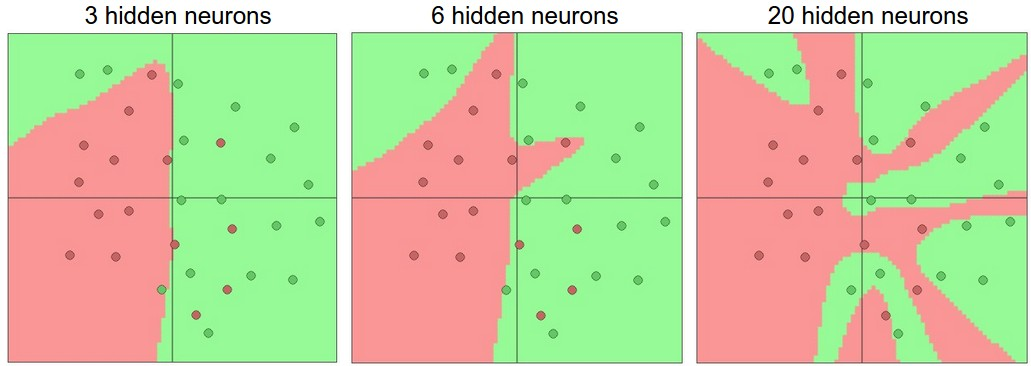

In [5]:
Image(filename=os.getcwd()+'/img/depth.jpeg')

** L2 regularization **
  
* A $W$ matrix that uses more features (having diffuse weights) is preferable, in general.
* L2 norm discourages larger weights through an elementwise quadratic penalty: $\sum_k \sum_l W_{k,l}^2$
* For example $W = [1,0,0,0]$ will have higher regularization loss than $W = [0.25,0.25,0.25,0.25]$

** Addition of regularization to the loss function **
 
* Adds a term, $\beta$, multiplied by the L2 norm of the weights $W$ to the loss function:

$$ L = - log \frac{e^{s_k}}{\sum_j e^{s_j}} + \beta L_2(W)$$ 

* $\beta$ is typically a hyper-parameter, often called `weight_decay`. 
* Determines how dominant this regularization term will be in the gradient computation. 

** Dropout **

* During training, dropout can be interpreted as sub-sampling a neural network.
* We randomly (and temporarily) delete a fraction the hidden neurons in the network. 
* This forces reduncancy in the learning and trains an ensemble of models (sub-networks).

---

###  Learning rate

** Choice of optimizer / learning rate **

* A general challenge with learning is "steep" versus "shallow" directions.
* Consider a problem in which we need to move in the shallow direction to converge.
* We need to equalize step sizes in these directions, in order to ensure progress.
* Else, we cotinute to make large steps in the steep direction and "thrash."

** Vanilla update (SGD) **

`x += learningrate * dx`

* Change the parameters along the negative gradient direction with learning_rate as a hyperparameter.
* Problem: SGD is slow! 

** Momentum update (and Nesterov Accelerated Gradient) **

`v = mu * v - learningrate * dx`

`x += v`

* $\mu$ will decay the previous $v$ 
* If we keep seeing a positive gradient in some direction, then we accumulate velocity.
* Problem: it can build-up too much velocity and over-shoot target basin, but performs better than SGD.

** Adagrad **

`cache += dx**2`

`x += learningrate * dx / (np.sqrt(catch) + 1e-7)`

* Scale the gradient by historical sum of squares of each dimention.
* 'Corrects' the problem of "over-shooting" step size in the steeper directions.

** RMSprop **

* Adagrad can suffer from decaying gradient. 
* Hinton suggested an improvement, where we simply make the cache leaky.
* This equalizes the step size, but does not converge directly 

`cache += decayrate * cache + (1 - decayrate) * dx**2`

`x += learningrate * dx / (np.sqrt(catch) + 1e-7)`

** ADAM **

* The default choice in practice.
* A combination of Adagrad and momentum.

--- 

### Example 2 layer NN in TF

* Two layer NN, with 50 hidden neurons, `RelU`, trained with SGD
* Train on MNIST, which has 28x28 images labeled 'A' through 'J' (10 classes)

In [1]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from datetime import datetime

# InteractiveSession to interleave build computation graph with running
# Newly constructed tf.Graph object remains as the default graph until you call sess.close()
sess = tf.InteractiveSession(graph=tf.Graph())
 
# Image params for MNIST data
image_size = 28
channels = 1
num_labels = 10

# Training params 
b_ = 0.0025 # Beta for L2 regularization
l_ = 0.5 # Learning rate for SGD 
num_steps = 20000 

### HELPER FUNCTIONS

def weight_variable(name,shape):
    
    ''' 
    Weights are variables that lives in TensorFlow's computation graph. We 
    initialize with a small amount of noise for symmetry breaking, to prevent 
    0 gradients, and with a slightly positive initial bias to avoid dead neurons.
    
    For Xavier initializer, (keep the scale of the gradients ~ the same in all layers), we can use:
    http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    
    For RelU networks, we can use:
    https://arxiv.org/pdf/1502.01852v1.pdf
    
    Note that we use get_variable:
    http://stackoverflow.com/questions/37098546/difference-between-variable-and-get-variable-in-tensorflow
    
    Input -
    name: Variable name
    shape: Shape for weight
    
    Output - 
    Weight variable definition
    '''
    
    # Xavier
    # return tf.get_variable(name,
    #                       shape=shape,
    #                       initializer=tf.contrib.layers.xavier_initializer()) 

    # He et al 
    return tf.get_variable(name,
                           shape=shape,
                           initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,
                                                                                      mode='FAN_IN',
                                                                                      uniform=False)) 
def bias_variable(shape):
    
    ''' Same as weight function '''
    
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### GRAPH

# Input data for the graph 
with tf.variable_scope('data') as scope:

    # Dim 1: None = The batch size can be of any size
    # Dim 2: Flattened image = image_size * image_size * channels 
    x = tf.placeholder(tf.float32, shape=[None, image_size * image_size * channels])
    y_ = tf.placeholder(tf.float32, shape=[None, num_labels])
    beta_regul = tf.placeholder(tf.float32)
    learning_rate = tf.placeholder(tf.float32)    
    global_step = tf.Variable(0)  

# Specify layers 
with tf.variable_scope('layers') as scope:
    
    # Layer 1 with 50 hidden neurons
    num_hidden_nodes_1 = 50
    W1 = weight_variable("W1",[image_size*image_size*channels,num_hidden_nodes_1])
    B1 = bias_variable([num_hidden_nodes_1])
    hidden_1 = tf.nn.relu(tf.matmul(x, W1) + B1)

    # Layer 2 that maps to classes 
    W2 = weight_variable("W2",[num_hidden_nodes_1,num_labels])
    B2 = bias_variable([num_labels])
    y_nn = tf.matmul(hidden_1,W2) + B2

# Forward prop to compute loss, back-prop gradient to compute gradient, update weights with vanilla SGD
with tf.variable_scope('fwd_back_prop') as scope:
    
    # Cross entropy loss with L2 regularization
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_nn)) + \
    beta_regul * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))
    
    # Learning rate annealing
    rate = tf.train.exponential_decay(learning_rate,global_step,num_steps/10,0.95,staircase=True)
    
    # Compute gradient and update weights with Vanilla SGD 
    train_step = tf.train.GradientDescentOptimizer(rate).minimize(cross_entropy)
        
# Compute accuracy and create summary nodes 
with tf.variable_scope('nn_summary') as scope:

    correct_prediction = tf.equal(tf.argmax(y_nn,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    loss_summary = tf.summary.scalar('Loss', cross_entropy)
    train_accuracy_summary = tf.summary.scalar('Train_accuracy', accuracy)

### TRAIN
    
# Set up log for TensorBoard
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(logdir)

# Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# Initialize variables 
sess.run(tf.global_variables_initializer())

# Create summary writer for logging
summary_writer = tf.summary.FileWriter(logdir, sess.graph)

# Train network 
for i in range(num_steps):

    # Fetch a minibatch 
    batch = mnist.train.next_batch(100)

    if i%100 == 0:

        # Batch data fed into graph computation, along with params
        feed_dict={x:batch[0], y_: batch[1], beta_regul: b_, learning_rate:l_}

        # Run graph
        # Returns tensors in first argument, [fetches]
        # Runs the graph fragment(s) to execute every operation and evaluate every Tensor in [fetches]
        _,loss_summ,train_accuracy_summ=sess.run([train_step,loss_summary,train_accuracy_summary],feed_dict=feed_dict)
        
        # Add summary metrics for tensorboard
        summary_writer.add_summary(loss_summ, i) 
        summary_writer.add_summary(train_accuracy_summ, i) 
        
sess.close()

tf_logs/run-20170323165233/
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Check results in tensorboard:

`tensorboard --logdir=${PWD} --port 6006`

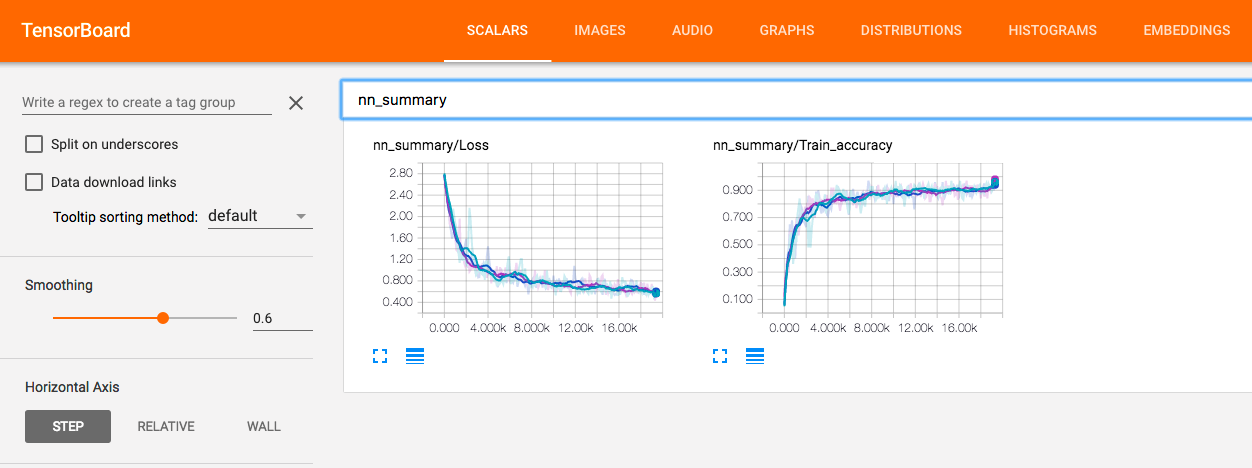

In [22]:
Image(filename=os.getcwd()+'/img/tb_1.png')

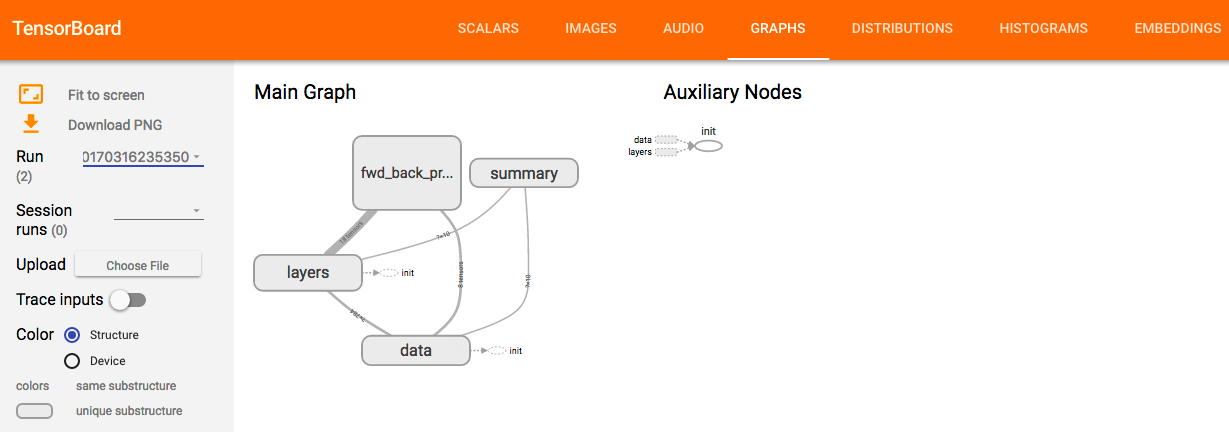

In [5]:
Image(filename=os.getcwd()+'/img/tb_graph_1.png')

--- 

###  Points and de-bugging

** Use epochs **

* One epoch means that every example has been seen once. 
* It is preferable to track epochs rather than iterations (as iterations depend on arbitrary setting of batch size).

** Sanity check the loss **

* We use cross-entropy loss function and 10 classes.
* `mean(softmax(logit))` for the initial batch should be ~ 0.1 and loss should then be `- log(0.1) ~ 2.30`

** Check the learning rate **

* The learning rate can be poorly matched to the choice of optimizer. 
* For example, `tf.train.GradientDescentOptimizer` does well with `0.5`.
* For example, `tf.train.AdamOptimizer` does well with `1e-4`.
* If the learning rate is too high, the optimiziation is unable to settle into "deeper" basis of the loss space. 
* If the learning rate too low, improvements will be linear.

** Check the weight initialization **

* In general, try initializing with small amount of positive noise for symmetry breaking.
* Initial values of weights may need to be re-scaled (e.g., `sqrt(n / 2.0)` for `RelU`).

** Risk of overfitting **

* Indicated by the gap between the training and validation / test accuracy. 


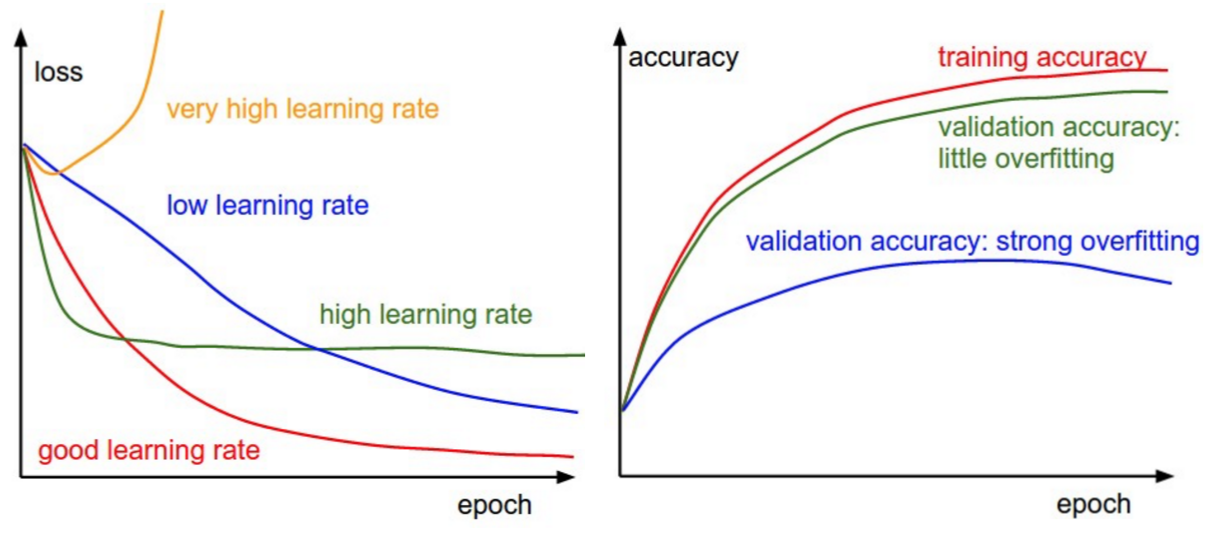

In [10]:
Image(filename=os.getcwd()+'/img/lr.png')

### ConvNets

** Spatial invariance in images **

* Processing each pixel in a 200 x 200 x 3 image would require fully connected neuron with 120,000 weights! 
* We want to use weight-sharing to learn common motifs (e.g., edges) independent of position in the image.
* We use the same weights to detect the same pattern in different parts of the array, as local values / motifs ar

** ConvNet principles **

* *** Local connections: *** In array data such as images, local groups of values , forming distinctive local motifs.
* *** Pooling: *** Merge semantically similar features into one, creating invariance to small shifts and distortions.

** ConvNet architecture **

Filter -

* In the below example, consider filter (below, $W_o$ 3 x 3 x 3). See interactive demo [here in CS231n notes.](http://cs231n.github.io/convolutional-networks/).
* At each filter position, we un-ravel the input (e.g., 1 x 9) and perform dot-product (e.g., 1 + 2 = 3 for the 1st channel, 1st position of $W1$).
* We sum across all channels for that position in the image (e.g., 3 for 1st channel, -2 for 2nd channel, 4 for 3rd channel, bias 1 sums to 6). 
* We "convolve" the filter along the image (e.g., using hyperparameters such as stride, etc) to produce an "activation."

Filter parameters - 

* ***Padding:*** Addition of zeros to the input volume. 
* ***Stride:*** Stride with which we slide the filter (e.g., 1 or 2 pixels).
* With image of size $N$ and $F$ as filter size, we can compute how many time the filter fits: $N - F / stride + 1$.
* Padding can be used to preserve the size of the input. We want this, because we want to be able to run many layers.
* With stride $S = 1$ and $F$ as the field size, zero padding set to $P = (F - 1) / 2$ produces output volume with same size spatially as inpout.

Depth -

* We "convolve" a set of $d$ filters (e.g., $W_o$, $W_1$) to produce an output volume of $d$ depth.
* We will stack these $d$ activation maps along the depth dimension and produce the output volume.
 
** Benefits ** 

* Consider the number of parameters if we want convert a `32x32x3` input to `28x28x6` activation.
* If fully connected, each neuron in the output is connected to all `32x32x3` neurons in the input.
* So, if fully connected: (32x32x3) x (28x28x6) = ~ 14.5M parameters, ~14.5M multiplies
* But, with convolutions: (5x5x3) x 6 = 450 parameters, 350k multiplies
* Thus, we use far fewer multiplies/flops and fewer parameters

** References **

* [Karpathy review of ConvNets](https://www.youtube.com/watch?v=u6aEYuemt0M)


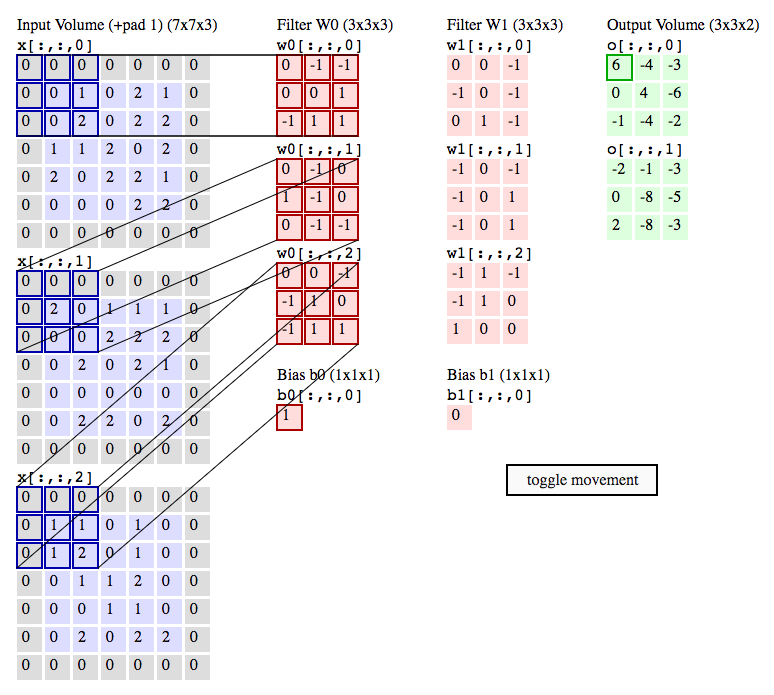

In [14]:
Image(filename=os.getcwd()+'/img/conv.png')

Non-linearity - 

* Conv is linear transformation of the input.
* We introduce non-linear operations between conv layers (e.g., RelU, which replaces all negative pixels with zero).

Pooling - 

* Reduce the spatial size of the representation, reducing parameters and, thus, controlling overfitting.
* Define a spatial neighborhood (for example, a 2×2 window) and perform an operation on it (e.g., max, avg).
* Max pooling  takes the largest element from the rectified feature map within that window.
* No parameters! Perform a fixed function.

Fully connected - 

* Every neuron in the output is connected to the entire input volume.
* Apply Softmax function to the output, resulting in a vector that sums to one.

--- 

### ConvNet architectures 

** AlexNet, 2012 **

* ILSVRC error: 15.3%
* Architecture: 5 Conv layers, 3 Pool layers, 3 FC layers, RelU non-linearity, drop-out
* CONV1: `227x227x3` input with `96 11x11` filters at stride 4. `(227-11)/4+1 = 55` activation size. Output is `55x55x6`.
* Training: SGD with momentum, 1e-2 learning rate, and 5e-4 L2 weight decay

** AlexNet vs. LeNet, 1998 **

* Data: More data (10e6 vs 10e3)
* Compute: GPUs (20x speedup)
* Algorithm: Deeper (8 layers), new regularization (dropout), non-linearity (RelU)
* Infrastructure: CUDA

** [ResNet, 2015](https://arxiv.org/pdf/1512.03385.pdf) **

* Every conv layer operates on the volume before it.
* Plain networks don't get better (often worse) as we add layers.
* Resnet adds skip connections between layers, which results in monotonically better performance as we add layers.
* Improvement is due [gradient can flow through the network](http://karpathy.github.io/neuralnets/) during [backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b#.asrywz6oo).
* Addition operations are gradient distributors.
* ILSVRC error: 3.6%

** References **

* [Review of ConvNet archs](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/)
* [ConvNet hyperparameters](https://adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/))
* [Discussion of ResNet](https://blog.acolyer.org/2017/03/22/convolution-neural-networks-part-3/)

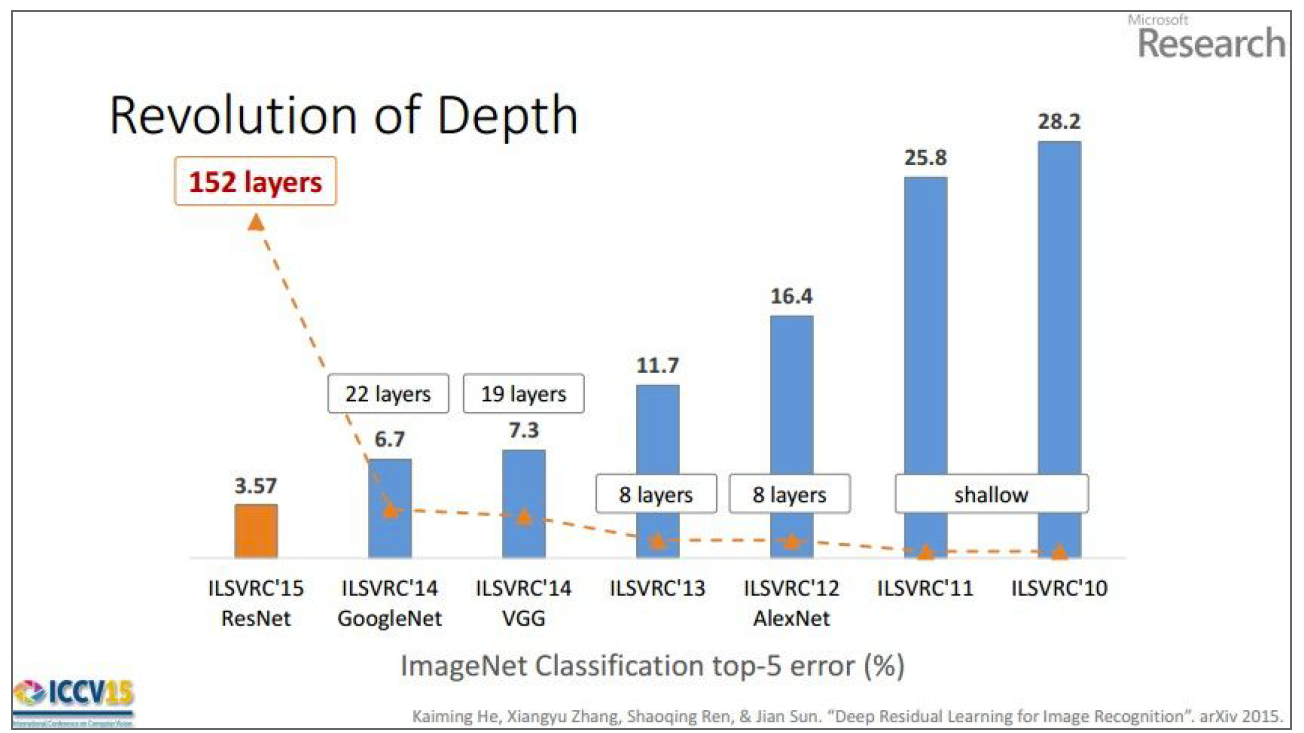

In [3]:
Image(filename=os.getcwd()+'/img/stateofart.png')

### Example 2 layer ConvNet in TF
 
Input data - 

* We can apply a series of random distortions to artificially increase the data set size.
* For example, randomly flip the image from left to right and distort the image brightness / contrast.

Network - 

* Two layer CNN, first layer has depth 32, second has depth 64. Both applied with same padding and stride 1.
* Max pooling operations after each conv layer collectivly down-sample the image by 4x.
* Apply fully connected layer applied to downsampled image, with 1024 neurons.


ERROR:root:Line magic function `%autoreload` not found.


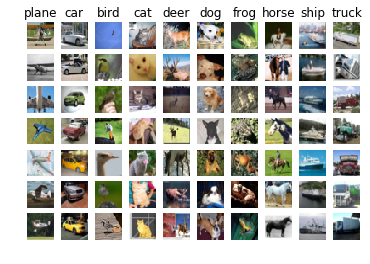

('Train data shape: ', (49000, 3072))
('Train labels shape: ', (49000, 10))
('Validation data shape: ', (1000, 3072))
('Validation labels shape: ', (1000, 10))
('Test data shape: ', (1000, 3072))
('Test labels shape: ', (1000, 10))


In [2]:
### CIFAR10 data

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from cs231n_module.data_utils import load_CIFAR10

num_labels = 10

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%autoreload
%matplotlib inline
%load_ext autoreload

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
   
    """ Load the CIFAR-10 dataset (N, 32, 32, 3) from disk. 
        Preprocess by subtracting mean.
  
      Args:
        num_training: N x 28 x 28 tensor
        num_validation: N x 1 vector, with each element the index of label
        num_test: 

      Returns:
        X_train: num_training x 3072 (32 * 32 * 3) tensor
        y_train: num_training x 1
        X_val: num_validation x 3072
        y_val: num_validation x 1
        X_test: num_test x 3072
        y_test: num_test x 1 """
    
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n_module/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Show examples of training images from each class
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 7
    
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

    # Subsample the data
    mask = range(num_training,num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: Subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
train_dataset_cifar10, train_labels_cifar10, valid_dataset_cifar10, valid_labels_cifar10, test_dataset_cifar10, test_labels_cifar10 = get_CIFAR10_data()

train_dataset_cifar10 = train_dataset_cifar10.astype(np.float32)
valid_dataset_cifar10 = valid_dataset_cifar10.astype(np.float32) 
test_dataset_cifar10 = test_dataset_cifar10.astype(np.float32)

train_labels_cifar10 = (np.arange(num_labels) == train_labels_cifar10[:,None]).astype(np.float32)
valid_labels_cifar10 = (np.arange(num_labels) == valid_labels_cifar10[:,None]).astype(np.float32)
test_labels_cifar10 = (np.arange(num_labels) == test_labels_cifar10[:,None]).astype(np.float32)

print('Train data shape: ', train_dataset_cifar10.shape)
print('Train labels shape: ', train_labels_cifar10.shape)
print('Validation data shape: ', valid_dataset_cifar10.shape)
print('Validation labels shape: ', valid_labels_cifar10.shape)
print('Test data shape: ', test_dataset_cifar10.shape)
print('Test labels shape: ', test_labels_cifar10.shape)

Expected performance - 

* Based upon [TF tutorial](https://www.tensorflow.org/tutorials/deep_cnn), a network similar to the below CNN (two conv layers) achieves a peak performance of about 86% accuracy on CIFAR-10 within a few hours of training time on a GPU.


In [3]:
# Variables
num_steps = 20000
batch_size = 50
patch_size = 5
xavier_init = True
learning_rate = 1e-4
opt = tf.train.AdamOptimizer
b_ = 0.0025 
          
def weight_variable(name,shape):
    
    ''' 
    Weights are variables that lives in TensorFlow's computation graph. We 
    initialize with a small amount of noise for symmetry breaking, to prevent 
    0 gradients, and with a slightly positive initial bias to avoid dead neurons.
    
    For Xavier initializer, (keep the scale of the gradients ~ the same in all layers), we can use:
    http://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    
    For RelU networks, we can use:
    https://arxiv.org/pdf/1502.01852v1.pdf
    
    Note that we use get_variable:
    http://stackoverflow.com/questions/37098546/difference-between-variable-and-get-variable-in-tensorflow
    
    Input -
    name: Variable name
    shape: Shape for weight
    
    Output - 
    Weight variable definition
    '''
    
    # Xavier
    if xavier_init:
        return tf.get_variable(name,
                               shape=shape,
                               initializer=tf.contrib.layers.xavier_initializer()) 

    # He et al 
    else:
        return tf.get_variable(name,
                               shape=shape,
                               initializer=tf.contrib.layers.variance_scaling_initializer(factor=2.0,
                                                                                          mode='FAN_IN',
                                                                                          uniform=False)) 
def bias_variable(shape):
    
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    
    ''' Output feature map has the same spatial dimensions as the input feature map. '''
    
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    
    ''' Down-sample feature map by 2x. '''
    
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def conv_reformat(dataset):
    
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    return dataset

# Choose DS to run
run_cifar10 = True

if run_cifar10:

    ### CIFAR-10
    image_size = 32
    num_channels = 3
    num_labels = 10

else: 
    
    ### MNIST
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
    image_size = 28
    num_channels = 1
    num_labels = 10

# Build graph
graph = tf.Graph()
with graph.as_default():

    with tf.name_scope('data'):
    
        # Get batches
        # The input images x will consist of a 2d tensor of floating point numbers. 
        # Here we assign it a shape of [None, 784], with 784 as the dimensionality of a single flattened 28 by 28 pixel MNIST image
        # None indicates that the first dimension, corresponding to the batch size, can be of any size. 
        
        tf_train_dataset = tf.placeholder(tf.float32, shape=[None, image_size * image_size * num_channels])
        x_image = tf.reshape(tf_train_dataset, [-1,image_size,image_size,num_channels])
        tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
        keep_prob = tf.placeholder(tf.float32)
        beta_regul = tf.placeholder(tf.float32)
        global_step = tf.Variable(0)  
        
    with tf.variable_scope('conv1') as scope:

        # First convolution, followed by down-sampling
        
        depth_conv1 = 32
        W_conv1 = weight_variable('W_c1',[patch_size, patch_size, num_channels, depth_conv1])
        b_conv1 = bias_variable([depth_conv1])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = max_pool_2x2(h_conv1)

    with tf.variable_scope('conv2') as scope:
        
        # Second convolution, followed by down-sampling
        
        depth_conv2 = 64
        W_conv2 = weight_variable('W_c2',[patch_size, patch_size, depth_conv1, depth_conv2])
        b_conv2 = bias_variable([depth_conv2])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = max_pool_2x2(h_conv2)

    # Now the image size has been reduced by 4x
    # Add a fully-connected layer with 1024 neurons (processing on the entire feature map)  
    with tf.variable_scope('fc') as scope:
    
        depth_fc = 1024
        W_fc1 = weight_variable('W_fc1',[image_size // 4 * image_size // 4 * depth_conv2, depth_fc])
        b_fc1 = bias_variable([depth_fc])

        h_pool2_flat = tf.reshape(h_pool2, [-1, image_size // 4 * image_size // 4 * depth_conv2])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

        W_fc2 = weight_variable('W_fc2',[depth_fc, num_labels])
        b_fc2 = bias_variable([num_labels])
        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    with tf.variable_scope('conv_summary') as scope:
          
        # Apply softmax nonlinearity to the output of the network 
        # Calculates the cross-entropy between the normalized predictions and a 1-hot encoding of the label
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=y_conv)) + \
                        beta_regul * (tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2) + tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2))
        
        rate = tf.train.exponential_decay(learning_rate,global_step,num_steps/10,0.95,staircase=True)
        train_step = opt(rate).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(tf_train_labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        loss_summary = tf.summary.scalar('Loss', cross_entropy)
        train_accuracy_summary = tf.summary.scalar('Train accuracy', accuracy)

### Log
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(logdir)
    
with tf.Session(graph=graph) as session:
    
    # Initialize
    tf.initialize_all_variables().run()
    
    # Summary writer
    summary_writer = tf.summary.FileWriter(logdir, session.graph)
    
    # Step
    for step in range(num_steps):
        
        if run_cifar10:

            offset = (step * batch_size) % (train_labels_cifar10.shape[0] - batch_size)
            batch_data = train_dataset_cifar10[offset:(offset + batch_size), :]
            batch_labels = train_labels_cifar10[offset:(offset + batch_size), :]
        
        else:
            
            batch = mnist.train.next_batch(batch_size)
            batch_data = batch[0]
            batch_labels = batch[1]

        feed_dict = {tf_train_dataset : batch_data, 
                     tf_train_labels : batch_labels,
                     beta_regul : b_,
                     keep_prob: float(0.5)}
        
        # Loss metrics
        if (step % 10 == 0):
            _,loss_summ,train_accuracy_summ=session.run([train_step,loss_summary,train_accuracy_summary],feed_dict=feed_dict)
            summary_writer.add_summary(loss_summ, step) 
            summary_writer.add_summary(train_accuracy_summ, step) 

INFO:tensorflow:Summary name Train accuracy is illegal; using Train_accuracy instead.


INFO:tensorflow:Summary name Train accuracy is illegal; using Train_accuracy instead.


tf_logs/run-20170323011025/
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Detection

** Problems **

1) Classification and localization

* Identify a single class and bounding box.
* Fully connected layer(s) tied to the conv feature map with two heads.
* Classification head:  output classes (train with softmax loss)
* Regression head: Fully connected layer(s) tied to the conv feature map that output 4 numbers for the location of the class (train with L2 loss)

2) Detection

* Identify all instances with bounding box for a set of classes.

** Datasets **

* VOC: 2.4 mean objects / image; 20 classes
* ILSVRC 2014: 1.1 mean objects / image; 200 classes
* MS COCO 2014: 7.2 mean objects / image; 80 classes

** Region proposal **

Brute force approach: 

* Slide a window across the image

[Region proposal](https://arxiv.org/pdf/1502.05082.pdf): 

* Fast, class-agnostic object detector (looking for blob-like structures).
* Many methods to choose from. Based upon above paper, `EdgeBoxes` appears preferable.

** [R-CNN (2014)](https://arxiv.org/abs/1311.2524) **

Steps

* Region proposal (e.g., selective search): Get a set (e.g., 2000) of regions.
* CNN: For each region proposal, run CNN to outputs image features passed to classification and regression.
* Fully connected layers: Produce feature map on which we perform final classification / regression.
* Classification: A set of binary SVMs to classify image regions.
* Regression: Apply bounding box regressor to correct for poor region proposals.

Problems
 
* Must run forward pass of CNN for each region proposal
* Offline training of networks heads.
* Training time (on Pascal VOC 2007) 84 hours
* Inference is slow (on Pascal VOC 2007): 47s / image

** [Fast R-CNN (2015)](https://arxiv.org/pdf/1504.08083.pdf) **

Steps [see excellent slide deck](http://www.robots.ox.ac.uk/~tvg/publications/talks/fast-rcnn-slides.pdf) 

* CNN: Run CNN on high res input image.
* Region proposal: Run external region proposal method on the conv feature map.
* Pooling: Apply RoI pooling to make it low-res, which is needed for fully connected layers.
* Fully connected layers.
* Training time (on Pascal VOC 2007): 9.5 hours
* Inference is faster (on Pascal VOC 2007): 0.32s / image

** [Faster R-CNN (2015)](https://arxiv.org/pdf/1506.01497.pdf) **

Steps

* CNN: Run on high res image.
* Region proposal network: No need for external region proposals! Produces region proposals from CONV feature map.


https://arxiv.org/pdf/1607.07032.pdf



** Metrics **

* IoU: Intersection over untion
* TP: IoU with a ground truth box greater than a threashold (~0.5)
* AP: Combine detections from all test images, draw precision / recall curve per class, AP is the region under the curve